In [28]:
!pip install numpy matplotlib

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Генерация тестового временного ряда
def generate_time_series(length=1000, noise_level=0.5, trend_magnitude=30, spike_magnitude=50):
    poo_weight = 4
    cat_with_poo = poo_weight + spike_magnitude

    np.random.seed(684)  # Для повторяемости
    series = np.random.normal(0, noise_level, length)

    # Добавляем событие А (тренд)
    trend_start = np.random.randint(length // 4, length // 2)
    trend_end = trend_start + np.random.randint(20, 50)
    trend_change = np.linspace(0, trend_magnitude, trend_end - trend_start)
    series[trend_start:trend_end] += trend_change
    series[trend_end:] += trend_magnitude

    # Добавляем событие Б (всплеск)
    spike_start = np.random.randint(length // 2, 3 * length // 4)
    spike_peak = spike_start + np.random.randint(5, 10)
    spike_end = spike_peak + np.random.randint(5, 10)
    series[spike_start:spike_end] += spike_magnitude
    series[spike_end:] += poo_weight  # Y-изменение после всплеска

    print(f'poo: {poo_weight}, cat: {cat_with_poo}')

    return series


In [75]:
# Анализ временного ряда с улучшением
def analyze_series(series, noise_level=0.5, spike_threshold=3):
    smoothed_series = np.convolve(series, np.ones(10) / 10, mode='same')

    events = []

    # Обнаружение события А (тренд)
    trend_start, trend_end = None, None
    for i in range(1, len(smoothed_series)):
        diff = smoothed_series[i] - smoothed_series[i - 1]
        if abs(diff) > noise_level / 2:
            if trend_start is None:
                trend_start = i
            trend_end = i
        elif trend_start is not None:
            # Добавляем событие только если тренд длился достаточно долго
            if trend_end - trend_start > 10:
                events.append({
                    'type': 'Trend',
                    'start': trend_start,
                    'end': trend_end,
                    'magnitude': smoothed_series[trend_end] - smoothed_series[trend_start]
                })
            trend_start, trend_end = None, None

    # Обнаружение события Б (всплеск)
    spike_start, spike_peak, spike_end = None, None, None
    for i in range(len(series)):
        if (series[i] > smoothed_series[i] + spike_threshold) or (spike_start and series[i] > smoothed_series[spike_start] + spike_threshold):
            if spike_start is None:
                spike_start = i
            if spike_peak is None or series[i] > series[spike_peak]:
                spike_peak = i
        elif spike_start is not None:
            spike_end = i
            # Добавляем событие только если всплеск достаточно выражен
            if spike_end - spike_start > 3:
                events.append({
                    'type': 'Spike',
                    'start': spike_start,
                    'peak': spike_peak,
                    'end': spike_end,
                    'cat': series[spike_peak] - series[spike_start - 1],  # todo: use window avg instead of previous value, mby use avg on the smoothed series for the weight
                    'poo': series[spike_end + 1] - series[spike_start - 1]

                })
            spike_start, spike_peak, spike_end = None, None, None

    return events

poo: 4, cat: 54


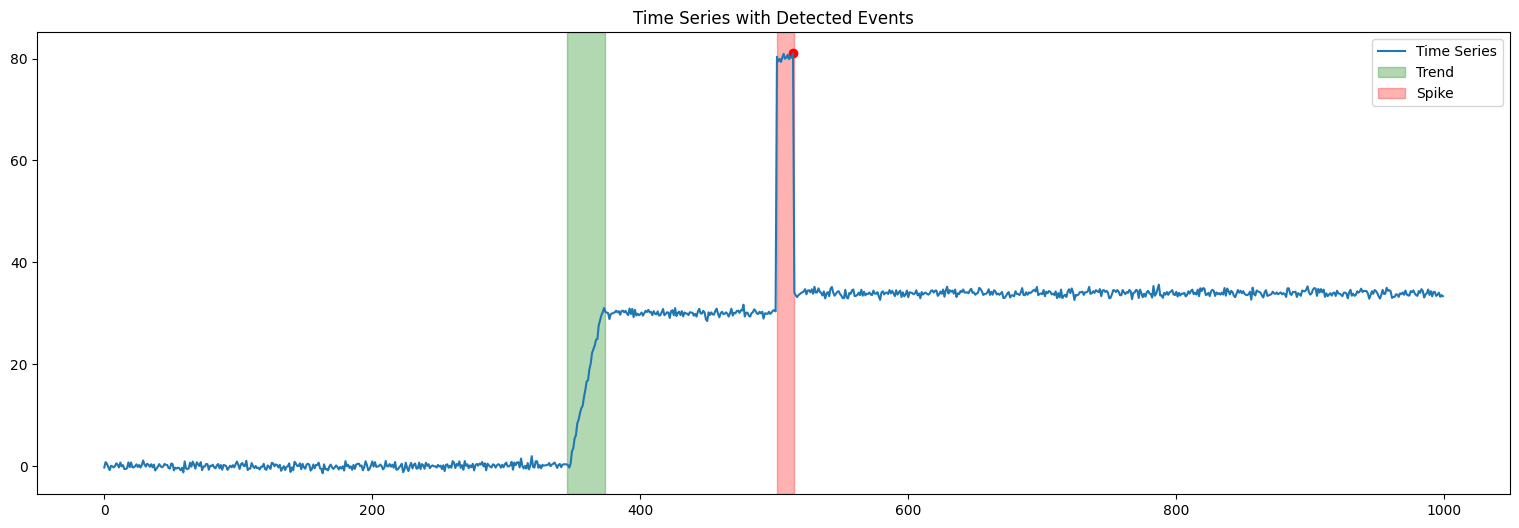

Detected Events:
{'type': 'Trend', 'start': 345, 'end': 374, 'magnitude': np.float64(29.152390491167257)}
{'type': 'Spike', 'start': 502, 'peak': 514, 'end': 515, 'cat': np.float64(50.674949994613584), 'poo': np.float64(3.163492809916189)}


In [76]:
# Тестирование
if __name__ == "__main__":
    time_series = generate_time_series()
    events = analyze_series(time_series)

    # Визуализация
    plt.figure(figsize=(19, 6))
    plt.plot(time_series, label="Time Series")
    for event in events:
        if event['type'] == 'Trend':
            plt.axvspan(event['start'], event['end'], color='green', alpha=0.3, label='Trend')
        elif event['type'] == 'Spike':
            plt.axvspan(event['start'], event['end'], color='red', alpha=0.3, label='Spike')
            plt.scatter(event['peak'], time_series[event['peak']], color='red')

    plt.legend()
    plt.title("Time Series with Detected Events")
    plt.show()

    print("Detected Events:")
    for event in events:
        print(event)